<a href="https://colab.research.google.com/github/MasoudMoeini/Google-Street-View-Images-Blur-Detection/blob/main/SBDN_Zhao_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
from PIL import Image
import glob
import os
import numpy as np

In [46]:
from numpy import *
images_folder= "train/dataset/train_data/1204source/*.bmp"
labels_folder = "train/dataset/train_data/1204gt/"
def data_preprocessing(images_folder,labels_folder):
  total_img = []
  label = []
  files = glob.glob (images_folder)
  for myFile in files:
      image_name=os.path.split(myFile)[1]
      img = Image.open(myFile)
      new_img = img.resize((224, 224))
      image = array(new_img)
      new_label=Image.open(labels_folder+image_name)
      new_label = new_label.resize((224, 224))
      label_image = array(new_label)
      label.append (label_image)
      total_img.append (image)
  total_img = np.array(total_img)
  label = np.array(label)
  label= np.reshape(label,[label.shape[0],label.shape[1],label.shape[2]])
  total_img= np.reshape(total_img,[total_img.shape[0],total_img.shape[1],total_img.shape[2],total_img.shape[3]])
  return label,total_img

In [47]:
labels,images=data_preprocessing(images_folder,labels_folder)

In [22]:
labels.shape

(1204, 224, 224)

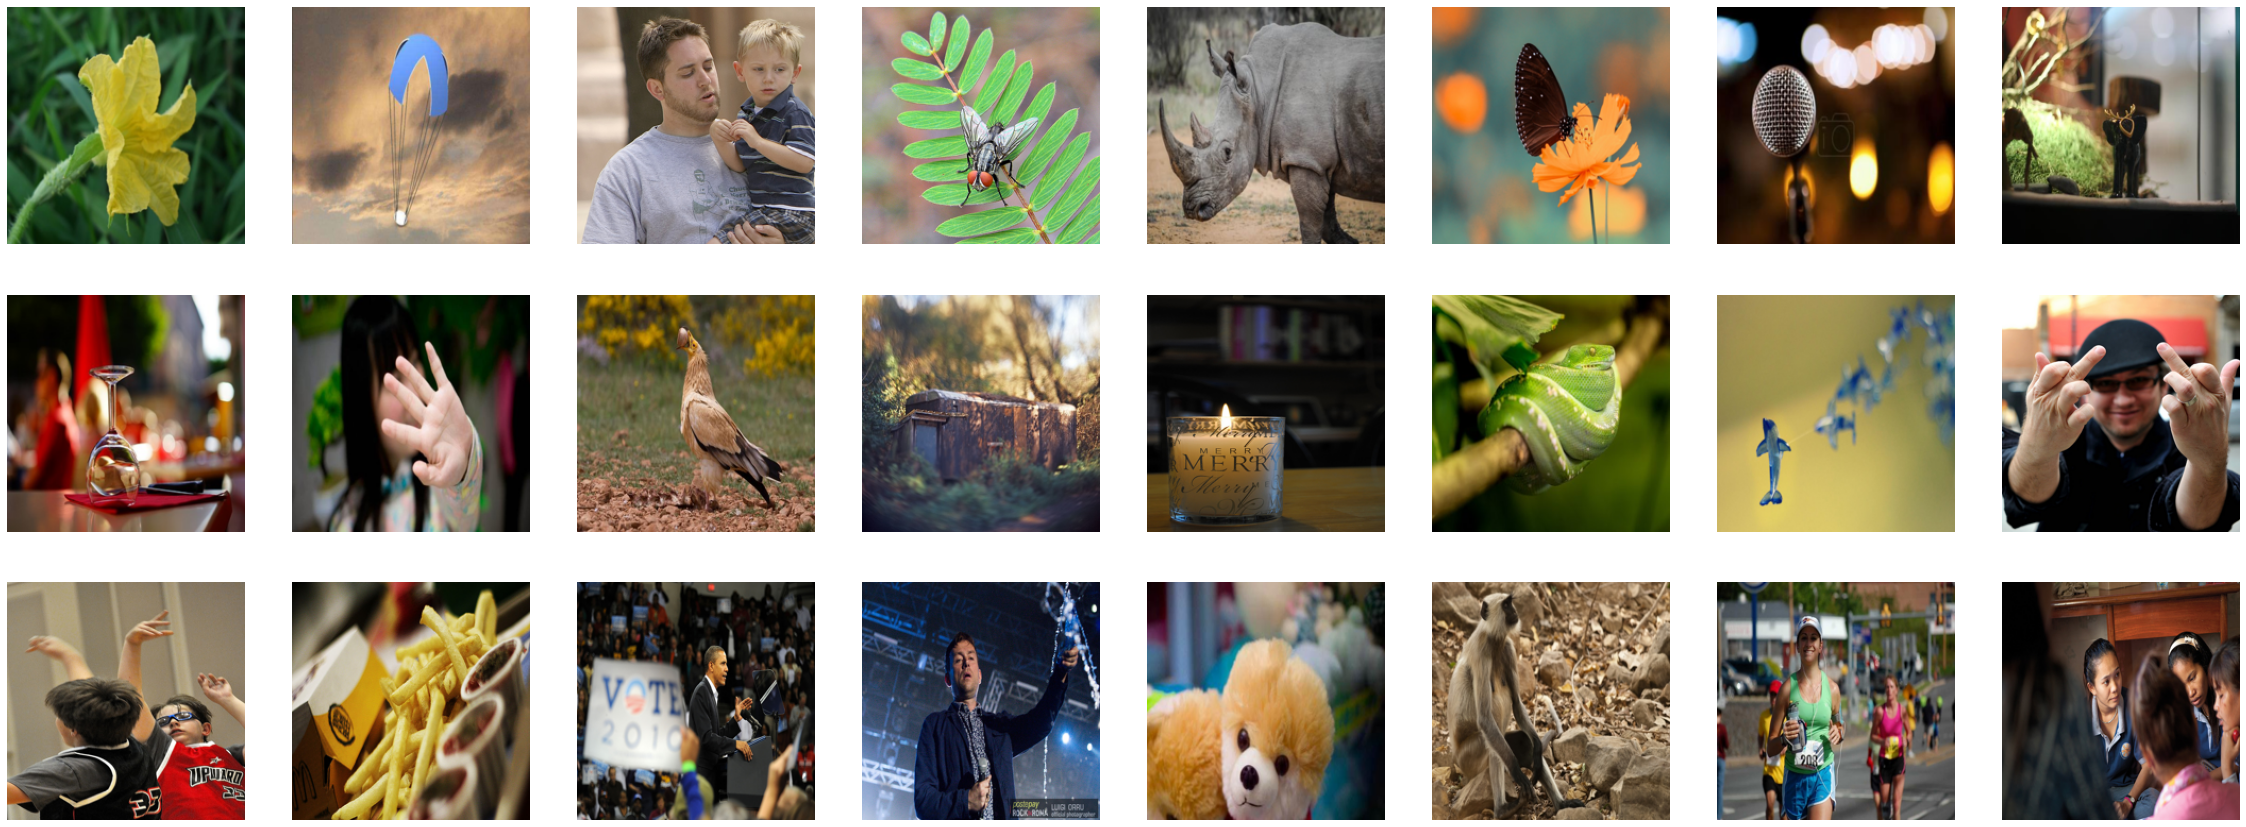

In [48]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(40, 15))
columns = 8
rows = 3
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns,i+1)
    plt.imshow(images[i],cmap='binary')
    plt.axis("off")
plt.show()

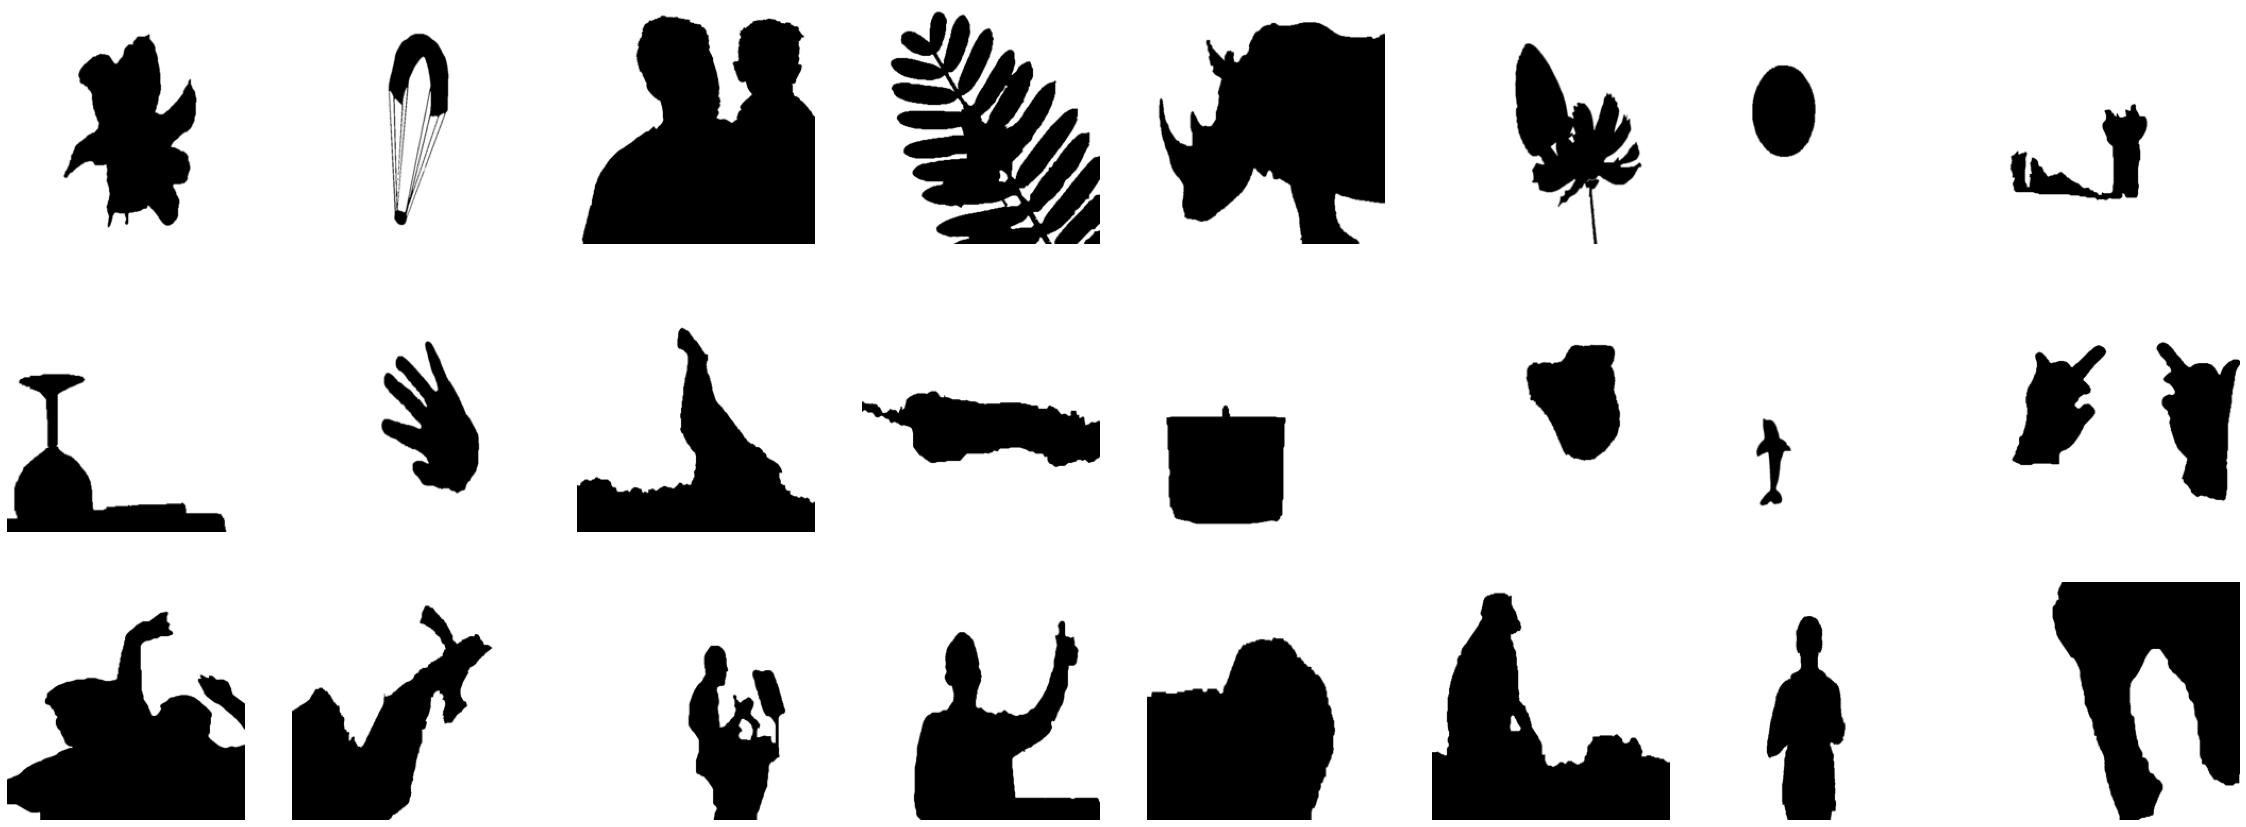

In [49]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(40, 15))
columns = 8
rows = 3
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns,i+1)
    plt.imshow(labels[i],cmap='binary')
    plt.axis("off")
plt.show()

In [26]:
images.shape

(1204, 224, 224, 3)

In [31]:
labels.shape

(1204, 224, 224)

In [32]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential, Model,load_model
from keras.optimizers import gradient_descent_v2 
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from keras import regularizers

In [33]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [34]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [37]:
def decoder_network(X):
    #x_input = layers.Input(shape=(147))
    #x = keras.layers.Reshape([7,7,3])(dX)
    x = layers.Conv2DTranspose(2048, (3, 3), strides=2, activation="relu", padding="same")(X)
    x = layers.Conv2DTranspose(512, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="relu",kernel_regularizer=regularizers.L2(l2=0.0005),
      bias_regularizer=regularizers.L2(l2=0.005), padding="same")(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="sigmoid",kernel_regularizer=regularizers.L2(l2=0.0005),
      bias_regularizer=regularizers.L2(l2=0.005), padding="same")(x)
    output = layers.Conv2DTranspose(1, (3, 3), strides=1, activation="sigmoid", padding="same",kernel_regularizer=regularizers.L2(l2=0.005),
      bias_regularizer=regularizers.L2(l2=0.0005), name="ident")(x)
    #model = Model(inputs=X, outputs=output, name='decoder_network')
    return output

In [35]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [38]:
def ResNet50():
    X_input = layers.Input(shape=(224, 224, 3))
    X = data_augmentation(X_input)
    X = layers.Rescaling(1./255)(X)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    #7*7*2048
    output1=decoder_network(X)
    #X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    #X = Flatten()(X)
    #X = Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(X)
    #X = Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(X)
    #main = Dense( 1,activation='sigmoid', name='main',kernel_initializer=glorot_uniform(seed=0))(X)
    model = Model(inputs=X_input, outputs=output1, name='ResNet50')
    return model

In [39]:
model= ResNet50()

In [40]:
class StopOnPoint(tf.keras.callbacks.Callback):
    def __init__(self, point):
        super(StopOnPoint, self).__init__()
        self.point = point
    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["accuracy"]
        if accuracy >= self.point:
            self.model.stop_training = True
callbacks = [StopOnPoint(0.99)]

In [41]:
loss1=tf.keras.losses.MeanSquaredError()
#loss2=tf.keras.losses.BinaryCrossentropy()
model.compile(keras.optimizers.Adam(learning_rate=1e-3),loss = [loss1],metrics=["accuracy"])

In [64]:
x_train = images.astype(np.float32)/ 255.0
y_train=labels.astype(np.float32)/ 255.0
y_train=(y_train)

In [65]:
history = model.fit(x_train,y_train, epochs=120,batch_size=25, validation_split=0.0,shuffle=True,callbacks=[callbacks])
model.save('sbdn-zhao-model.h5')

Epoch 1/120
 6/49 [==>...........................] - ETA: 25s - loss: 0.2662 - accuracy: 0.6806

49/49 [==============================] - 29s 594ms/step - loss: 0.2658 - accuracy: 0.6756
Epoch 2/120
49/49 [==============================] - 28s 579ms/step - loss: 0.2340 - accuracy: 0.6754
Epoch 3/120
49/49 [==============================] - 28s 577ms/step - loss: 0.2241 - accuracy: 0.6752
Epoch 4/120
49/49 [==============================] - 29s 582ms/step - loss: 0.2121 - accuracy: 0.6755
Epoch 5/120
49/49 [==============================] - 28s 580ms/step - loss: 0.1980 - accuracy: 0.6756
Epoch 6/120
49/49 [==============================] - 28s 580ms/step - loss: 0.1916 - accuracy: 0.6756
Epoch 7/120
49/49 [==============================] - 28s 580ms/step - loss: 0.1822 - accuracy: 0.6757
Epoch 8/120
49/49 [==============================] - 28s 580ms/step - loss: 0.1730 - accuracy: 0.6886
Epoch 9/120
49/49 [==============================] - 28s 580ms/step - loss: 0.1649 - accuracy: 0.7311
Epoch 10/120
49/49 [==============================] - 28s 580ms/step - loss: 0.1605 - accuracy

In [92]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy'])


In [93]:
import pandas as pd
hist_df = pd.DataFrame(history.history)
hist_csv_file = 'sbdn-zaho-history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

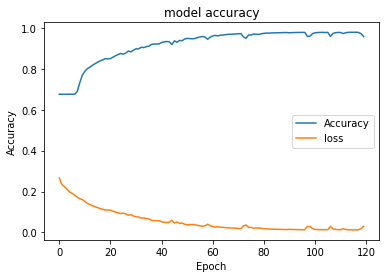

In [66]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
#plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","loss"])
plt.show()

## Evaluation Shi et al (CUHK)

In [67]:
images_folder= "train/dataset/test_data/CUHK/xu100-source/*.bmp"
labels_folder = "train/dataset/test_data/CUHK/xu100-gt/"
def data_preprocessing(images_folder,labels_folder):
  total_img = []
  label = []
  files = glob.glob (images_folder)
  for myFile in files:
      image_name=os.path.split(myFile)[1]
      img = Image.open(myFile)
      new_img = img.resize( (224, 224))
      image = array(new_img)
      new_label=Image.open(labels_folder+image_name)
      new_label = new_label.resize((224, 224))
      label_image = array(new_label)
      label.append (label_image)
      total_img.append (image)
  total_img = np.array(total_img)
  label = np.array(label)
  label= np.reshape(label,[label.shape[0],label.shape[1],label.shape[2]])
  total_img= np.reshape(total_img,[total_img.shape[0],total_img.shape[1],total_img.shape[2],total_img.shape[3]])
  return label,total_img

In [68]:
shi_labels,shi_images=data_preprocessing(images_folder,labels_folder)

In [90]:
shi_labels.shape

(100, 224, 224)

In [91]:
shi_images.shape

(100, 224, 224, 3)

In [ ]:
from keras.models import load_model
images = shi_images
model = load_model("sbdn-zhao-model.h5")
predictions=[]
for i in range(images.shape[0]):
  img = images[i]
  img = img.astype(np.float32)/ 255.0
  img = np.expand_dims(img, -1)
  img = np.expand_dims(img, 0)
  pred = model.predict(img)
  predictions.append(pred)

In [73]:
ground_truth_total=shi_labels/255.0
ground_truth_total=np.where(ground_truth_total>0.5,1.0,0.0)

In [74]:
def get_mae(true_label, y_pred_label):
  absolute_error=[]
  for i in range(0,len(true_label)):
    #true_label = eval_labels[i]/255.0
    pp=np.where(((y_pred_label[i])[0])>0.5,1.0,0.0)
    y_pred=reshape(pp,[224,224])
    y_true=true_label[i]
    mae = tf.keras.losses.MeanAbsoluteError()
    m = mae(y_true, y_pred).numpy()
    absolute_error.append(m)
  return mean(absolute_error)
mean_absolute_error= get_mae(ground_truth_total,predictions)
print('Mean Absolute Error for Evaluation set: ',mean_absolute_error)

Mean Absolute Error for Evaluation set:  0.1004346699617347


In [75]:
from sklearn.metrics import precision_score,recall_score
threshoulds=[0.3,0.4,0.5,0.6,0.7]
beta2=0.2
def recall_precison(y_true,y_pred):
  OIS_F=[]
  Fb=[]
  for i in range(0,len(y_pred)):
    OIS_F_thr=[]
    fb_thr=[]
    for thr in threshoulds:
      pr=np.where(((y_pred[i])[0])>thr,1.0,0.0)
      pr=reshape(pr,[224,224])
      pred_precision_score=precision_score(y_true[i],pr, average='weighted')
      pred_recall_score=recall_score(y_true[i],pr, average='weighted')
      OIS=2*pred_precision_score*pred_recall_score/(pred_precision_score+pred_recall_score)
      fb=(1+beta2)*pred_precision_score*pred_recall_score/(beta2 * pred_precision_score+pred_recall_score)
      fb_thr.append(fb)
      OIS_F_thr.append(OIS)
    Fb.append(fb_thr)
    OIS_F.append(OIS_F_thr)
  return OIS_F,Fb

In [ ]:
OIS_array,Fb_array=recall_precison(ground_truth_total,predictions)

In [77]:
def Fb_score(Fb_array):
  best_Fb=[]
  for results in Fb_array:
    f_score=max(results)
    best_Fb.append(f_score)
  return np.nanmean(best_Fb)
mean_Fb_score= Fb_score(Fb_array)
print('Fb score: ',mean_Fb_score)

Fb score:  0.8471578475677687


In [78]:
def OIS_F_score(OIS_array):
  best_OIS_F=[]
  index_max=[]
  for results in OIS_array:
    f_score=max(results)
    best_OIS_F.append(f_score)
    index = results.index(f_score)
    index_max.append(index)
  return best_OIS_F,index_max
OIS_f1,indexes=OIS_F_score(OIS_array)
print('Average Optimal Image Scale F score: ',np.nanmean(OIS_f1))

Average Optimal Image Scale F score:  0.8609413609673244


## Evaluation DUT dataset

In [79]:
images_folder= "train/dataset/test_data/DUT/dut500-source/*.bmp"
labels_folder = "train/dataset/test_data/DUT/dut500-gt/"
def data_preprocessing(images_folder,labels_folder):
  total_img = []
  label = []
  files = glob.glob (images_folder)
  for myFile in files:
      image_name=os.path.split(myFile)[1]
      img = Image.open(myFile)
      new_img = img.resize( (224, 224))
      image = array(new_img)
      new_label=Image.open(labels_folder+image_name)
      new_label = new_label.resize((224, 224))
      label_image = array(new_label)
      label.append (label_image)
      total_img.append (image)
  total_img = np.array(total_img)
  label = np.array(label)
  label= np.reshape(label,[label.shape[0],label.shape[1],label.shape[2]])
  total_img= np.reshape(total_img,[total_img.shape[0],total_img.shape[1],total_img.shape[2],total_img.shape[3]])
  return label,total_img

In [80]:
dut_labels,dut_images=data_preprocessing(images_folder,labels_folder)

In [89]:
dut_labels.shape

(500, 224, 224)

In [88]:
dut_images.shape

(500, 224, 224, 3)

In [ ]:
images = dut_images
model = load_model("sbdn-zhao-model.h5")
predictions=[]
for i in range(images.shape[0]):
  img = images[i]
  img = img.astype(np.float32)/ 255.0
  img = np.expand_dims(img, -1)
  img = np.expand_dims(img, 0)
  pred = model.predict(img)
  predictions.append(pred)

In [82]:
ground_truth_total=dut_labels/255.0
ground_truth_total=np.where(ground_truth_total>0.5,1.0,0.0)

In [83]:
def get_mae(true_label, y_pred_label):
  absolute_error=[]
  for i in range(0,len(true_label)):
    #true_label = eval_labels[i]/255.0
    pp=np.where(((y_pred_label[i])[0])>0.5,1.0,0.0)
    y_pred=reshape(pp,[224,224])
    y_true=true_label[i]
    mae = tf.keras.losses.MeanAbsoluteError()
    m = mae(y_true, y_pred).numpy()
    absolute_error.append(m)
  return mean(absolute_error)
mean_absolute_error= get_mae(ground_truth_total,predictions)
print('Mean Absolute Error for Evaluation set: ',mean_absolute_error)

Mean Absolute Error for Evaluation set:  0.1199820631377551


In [84]:
from sklearn.metrics import precision_score,recall_score
threshoulds=[0.3,0.4,0.5,0.6,0.7]
beta2=0.2
def recall_precison(y_true,y_pred):
  OIS_F=[]
  Fb=[]
  for i in range(0,len(y_pred)):
    OIS_F_thr=[]
    fb_thr=[]
    for thr in threshoulds:
      pr=np.where(((y_pred[i])[0])>thr,1.0,0.0)
      pr=reshape(pr,[224,224])
      pred_precision_score=precision_score(y_true[i],pr, average='weighted')
      pred_recall_score=recall_score(y_true[i],pr, average='weighted')
      OIS=2*pred_precision_score*pred_recall_score/(pred_precision_score+pred_recall_score)
      fb=(1+beta2)*pred_precision_score*pred_recall_score/(beta2 * pred_precision_score+pred_recall_score)
      fb_thr.append(fb)
      OIS_F_thr.append(OIS)
    Fb.append(fb_thr)
    OIS_F.append(OIS_F_thr)
  return OIS_F,Fb

In [ ]:
OIS_array,Fb_array=recall_precison(ground_truth_total,predictions)

In [86]:
def Fb_score(Fb_array):
  best_Fb=[]
  for results in Fb_array:
    f_score=max(results)
    best_Fb.append(f_score)
  return np.nanmean(best_Fb)
mean_Fb_score= Fb_score(Fb_array)
print('Fb score: ',mean_Fb_score)

Fb score:  0.8304771159090248


In [87]:
def OIS_F_score(OIS_array):
  best_OIS_F=[]
  index_max=[]
  for results in OIS_array:
    f_score=max(results)
    best_OIS_F.append(f_score)
    index = results.index(f_score)
    index_max.append(index)
  return best_OIS_F,index_max
OIS_f1,indexes=OIS_F_score(OIS_array)
print('Average Optimal Image Scale F score: ',np.nanmean(OIS_f1))

Average Optimal Image Scale F score:  0.8315539755153603
